The [Smoluchowski equation](https://en.wikipedia.org/wiki/Smoluchowski_coagulation_equation) has analytical solutions for a few simple coagulation kernels (without the fragmentation part; see Appendix A4 in [Kenyon & Luu (1998)](https://ui.adsabs.harvard.edu/abs/1998AJ....115.2136K/abstract) for a summary and references therein).

In this notebook, we compares our results with the analytic solutions for two cases with a constant kernel and with a sum kernel.

---
PS: The results of solving the Smoluchowski equation numerically are known to depend on resolution, initial setup, and the length of time step (and also the `Python` environment and the machine used). It is thus normal if you get slightly different results. If you get qualitatively different results, be sure to test different setups.

# Import Modules

In [1]:
from astropy import units as u
from astropy import constants as c
import numpy as np
import scipy as sp
import scipy.optimize as spop
import mpmath as mp
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib nbagg
np.set_printoptions(edgeitems=5, linewidth=200, precision=6)
mp.mp.dps = 25

In [3]:
from rubble import Rubble, RubbleData

One may use `help(Rubble)` to take a quick look on the class. The output would look like:
```bash
Help on class Rubble in module rubble.rubble:

class Rubble(builtins.object)
 |  Rubble(num_grid, amin, amax, q, Sigma_d, rho_m=1.6, run_name='rubble_test', **kwargs)
 |  
 |  Simulate the local evolution of solid size distributions in Protoplanetary Disks (PPDs)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_grid, amin, amax, q, Sigma_d, rho_m=1.6, run_name='rubble_test', **kwargs)
 |      Initialize the radius/mass grid of solid particles, distribute solids and prepare kernels
 |      
 |      Parameters
 |      ----------
 |      num_grid : int
 |          number of grid cells along radius/mass grid
 |      amin : float
 |          minimum particle radius, in units of cm
 |      amax : float
 |          maximum particle radius, in units of cm
 |      q : float
 |          initial power law index of the size distribution
 |      Sigma_d : float
 |          total dust surface density, in units of g/cm^2
 |      rho_m : float
 |          material density of solids, in units of g/cm^3, default to 1.6
 |      kwargs
 |          other disk parameters and numerical parameters (some are necessary)
 |      
 |      About kwargs
 |      ------------
 
 ......
```

In [4]:
dt_1d = 86400; dt_1yr = dt_1d * 365.25

# Constant Kernel ($K_{ij} = 1$)

If $n_0$ is the initial number of particles with mass $m_i$, the number of bodies with mass $m_k = km_i$ at a time $t$ is
    
$$ n_k = n_0 f^2 (1 - f)^{k-1}, $$

where $f = 1/(1+0.5 \eta_1)$ and $\eta_1 = \alpha_c n_0 t$ is the dimensionless time.

In [5]:
# First, do a small-scale quick test
a_min = (1.0/ (4*np.pi/3 * 1.6))**(1/3); print("minimum dust size is ", a_min)
r = Rubble(101, a_min, 20*a_min, 0, 1.0, 
           delta_dist=a_min,  # initialized with a monodisperse distribution
           coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           run_name = "constK")

# the following line sets the kernel to const kernel
r._user_setup(test='constK')

minimum dust size is  0.5303922089735277


In [6]:
# we can check what flags are on 
# here we disabled fragmentation and only consider Epstein Stokes number, the kernel is thus static
r.show_flags()

frag_flag:                       False
bouncing_flag:                   False
mass_transfer_flag:              False
f_mod_flag:                      False
vel_dist_flag:                   False
simple_St_flag:                  True
full_St_flag:                    False
feedback_flag:                   False
uni_gz_flag:                     False
closed_box_flag:                 True
dyn_env_flag:                    False
static_kernel_flag:              True
debug_flag:                      False
flag_activated:                  True


In [7]:
# calculate the dimensionless time units (see Appendix A4 in Kenyon & Luu (1998))
n0 = r.Nk[1]
Aij = r.K[1][1] / r.vi_fac[1][1]
eta1 = 1 / (Aij * n0)
print(n0, Aij, Aij * n0, eta1)

1.0 1.0 1.0 1.0


In [8]:
# for a fast test run
r.run(eta1*250/dt_1yr, (eta1/4)/dt_1yr, (eta1)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


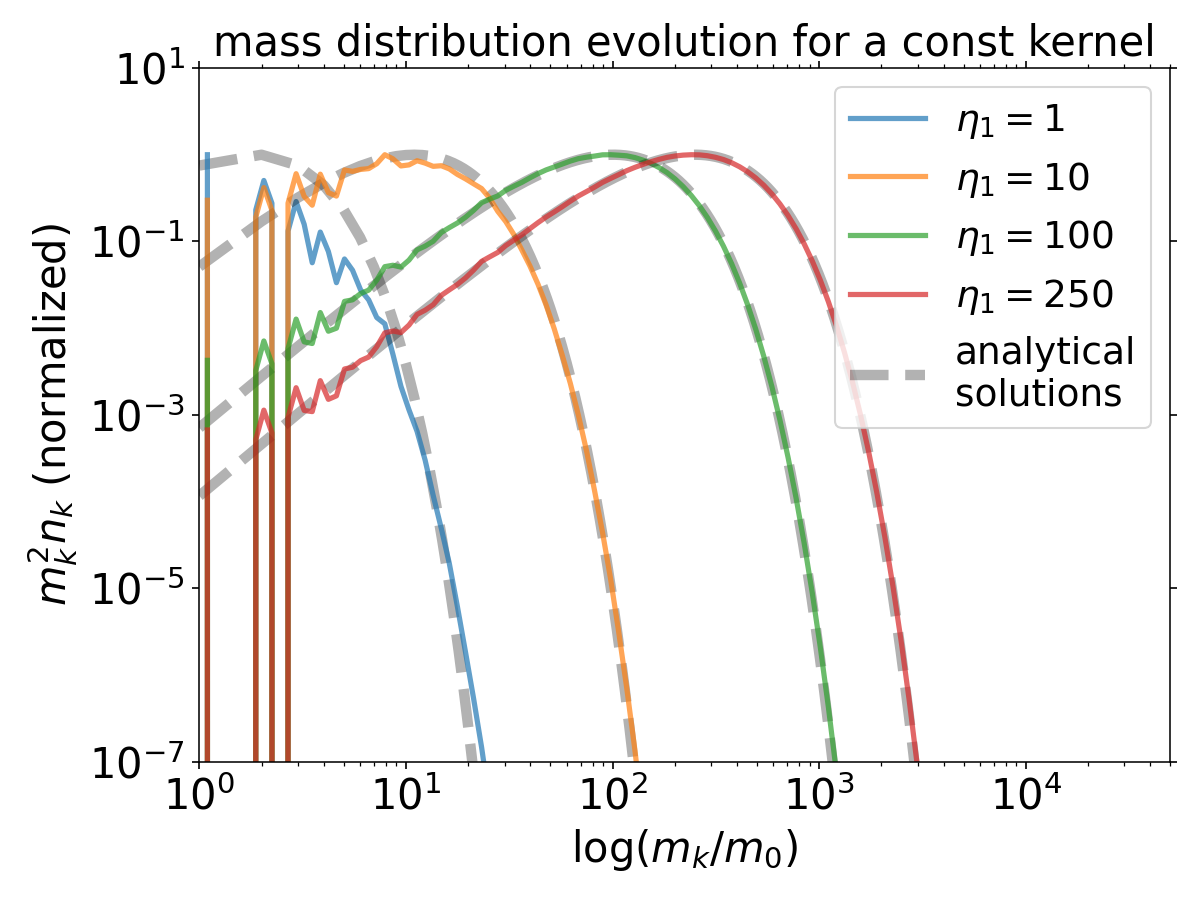

In [11]:
# plotting N = delta N / delta m, see Equation A32 in Kenyon & Luu (1998)
rd = RubbleData("constK.dat") # use RubbleData class to read in simulation output (try rd.__dict__ to see what's in there)
fig, ax = plt.subplots(figsize=(8, 6)); k = np.arange(1, 1e4);
tmp_Nk = rd.Nk[0]; tmp_n0 = tmp_Nk[1] / (rd.m[3] - rd.m[1]) / 15
for ntp in [1, 10, 100, 250]:
    f = 1 / (1 + 0.5 * ntp); f_nk = 1 * f**2 * (1 - f)**(k - 1) *k**2
    ax.loglog(k, f_nk/f_nk.max(), '--k', lw=5, alpha=0.3)
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * eta1))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.loglog(rd.m[2:-1]/rd.m[1], tmp_N / tmp_N.max(), lw=2.5, alpha=0.7, label=f'$\eta_1 = {ntp}$')

ax.loglog([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2)
ax.set(ylim=(1e-7, 10), xlim=(1, 5e4), xlabel=r'$\log(m_k/m_0)$', ylabel=r"$m_k^2 n_k$ (normalized)",
       title=r'mass distribution evolution for a const kernel')
fig.tight_layout()

### Now, for a larger-scale longer test

In [17]:
a_min = (1.0/ (4*np.pi/3 * 1.6))**(1/3); print("minimum dust size is ", a_min);
r = Rubble(254, a_min, a_min*1e2, 0, 1.0, 
           delta_dist=a_min,  # initialized with a monodisperse distribution
           coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           run_name = "constK_longer")

# the following line sets the kernel to const kernel
r._user_setup(test='constK')

minimum dust size is  0.5303922089735277


In [18]:
n0 = r.Nk[1]
Aij = r.K[1][1] / r.vi_fac[1][1]
eta1 = 1 / (Aij * n0)
print(n0, Aij, Aij * n0, eta1)

1.0 1.0 1.0 1.0


In [ ]:
# N.B.: this run will cost hours, better put in on HPC
r.run(tprime*10000/dt_1yr, (tprime/4)/dt_1yr, (tprime)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


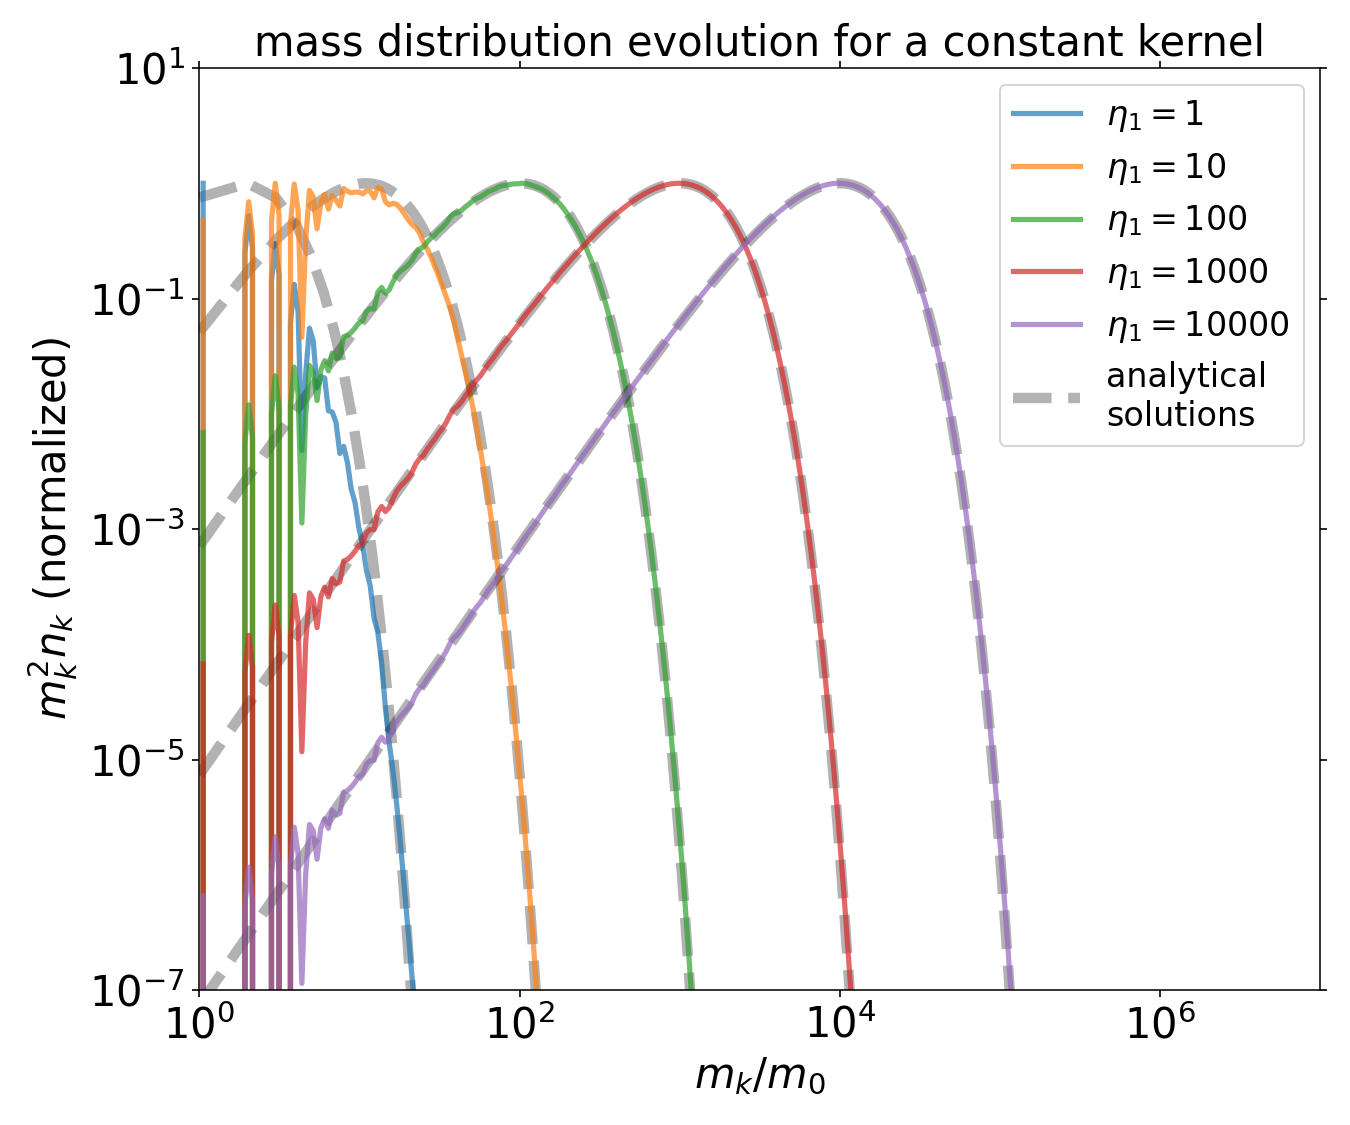

In [19]:
rd = RubbleData("constK_longer.dat")
fig, ax = plt.subplots(figsize=(9, 7.5)); k = np.arange(1, 2e5); tprime = 1.0
tmp_Nk = rd.Nk[0]; tmp_n0 = tmp_Nk[1] / (rd.m[3] - rd.m[1]) / 15
for ntp in [1, 10, 100, 1000, 10000]:
    f = 1 / (1 + 0.5 * ntp); f_nk = 1 * f**2 * (1 - f)**(k - 1) *k**2
    ax.loglog(k, f_nk/f_nk.max(), '--k', lw=5, alpha=0.3)
    
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * tprime))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.loglog(rd.m[2:-1]/rd.m[1], tmp_N / tmp_N.max(), lw=2.5, alpha=0.7, label=f'$\eta_1 = {ntp}$')

ax.loglog([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2, fontsize=16)
ax.set(ylim=(1e-7, 10), xlim=(1, 1e7), xlabel=r'$m_k/m_0$', ylabel=r"$m_k^2 n_k$ (normalized)",
       title=r'mass distribution evolution for a constant kernel')
fig.tight_layout()

# Sum Kernel ($K_{ij}=m_i + m_j$)

The solution for $A_{ij} = \beta_c (m_i + m_j)$ is

$$ n_k = n_0 \frac{k^{k-1}}{k!} f(1-f)^{k-1} \exp [-k(1-f)], $$

where $f = \exp(-\eta_2)$ and $\eta_2 = \beta_c n_0 t$ is the dimensionless time.

In [21]:
# exp[-k(1-f)] in the analytical solution is much larger than what numpy can handle, we need mpmath
mp.mp.dps = 200
lgk = np.linspace(0, 28, 256)
mpmpf = np.frompyfunc(mp.mpf, 1, 1)
lgk = mpmpf(lgk)
k = 10**lgk
mpfac = np.frompyfunc(mp.factorial, 1, 1)
mplog10 = np.frompyfunc(mp.log10, 1, 1)
mpexp = np.frompyfunc(mp.exp, 1, 1)
lgkfac = mplog10(mpfac(k))

In [22]:
# First, do a small-scale quick test

# again make the mass of the first bin = 1.0
a_min = (1.0/ (4*np.pi/3 * 1.6))**(1/3)
r = Rubble(254, a_min, 2e6, 0, 1.0, 
           delta_dist=a_min, coag2nearest=True,
           run_name="sumK", beta_c=1.0) # beta_c is the kernel coefficient: K_ij = beta_c (m_i + m_j)

# the following line sets the kernel to sum kernel
r._user_setup(test='sumK')

In [23]:
n0 = r.Nk[1]; beta_c = 1.0 ; eta2 = 1 / (beta_c * n0)
n0, beta_c * n0, eta2, eta2/dt_1yr

(1.0, 1.0, 1.0, 3.168808781402895e-08)

In [24]:
r.run(eta2*10/dt_1yr, (eta2/4)/dt_1yr, (eta2)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


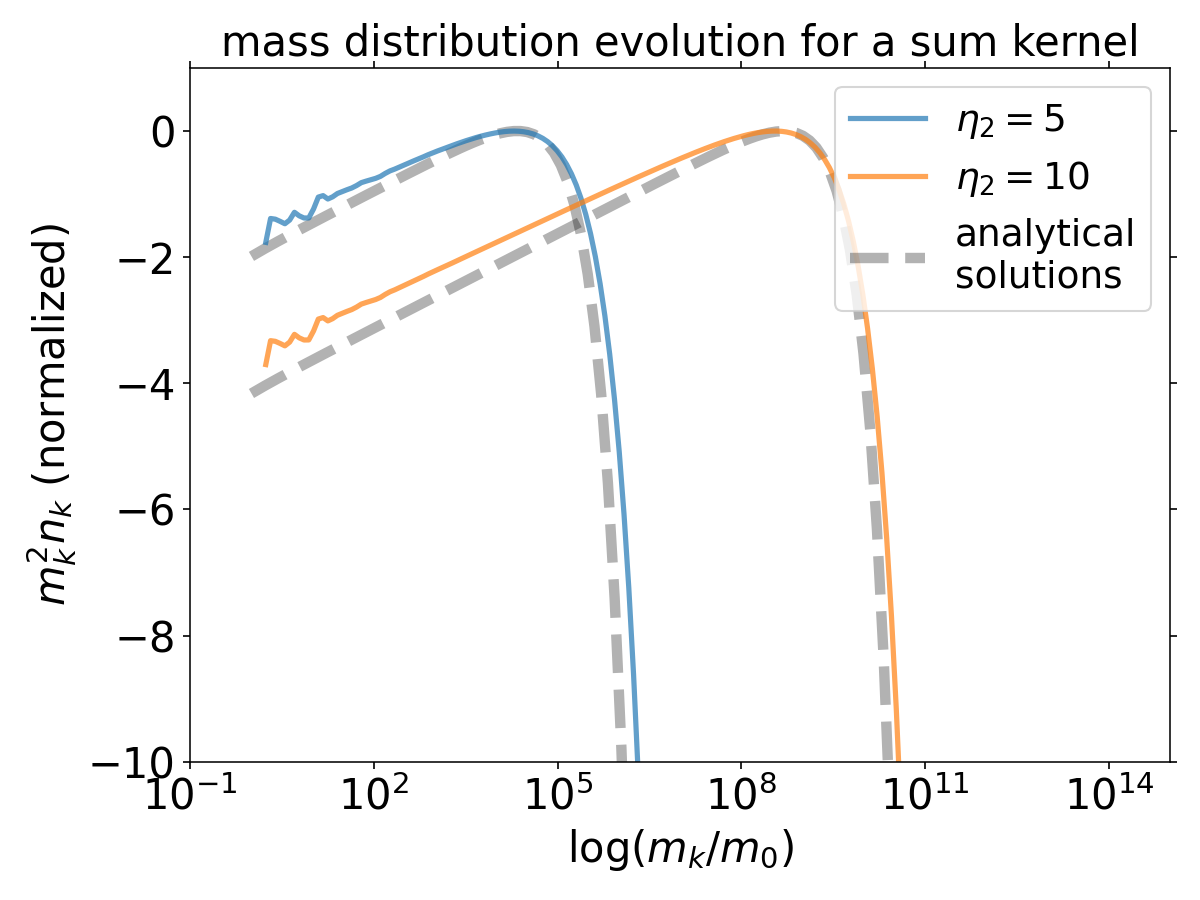

In [31]:
%%capture --no-stdout --no-display
# the line above remove warning messages
rd = RubbleData("sumK.dat")
fig, ax = plt.subplots(figsize=(8, 6)); maxis = rd.m[2:-1]/rd.m[1]
for ntp in [5, 10]:
    f = mp.exp(-ntp); 
    f_nk = (k-1)*lgk - lgkfac + mplog10(f * (1-f)**(k-1) * mpexp(-k*(1-f)) * k**2)
    ax.semilogx(k, f_nk - f_nk.max(), '--k', lw=5, alpha=0.3)
    
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * eta2))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.semilogx(maxis, np.log10(tmp_N / tmp_N.max()), lw=2.5, alpha=0.7, label=f'$\eta_2 = {ntp}$')
ax.semilogx([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2)
ax.set(xlabel=r'$\log(m_k/m_0)$', ylabel=r"$m_k^2 n_k$ (normalized)", ylim=(-10, 1), xlim=(0.1, 1e15), 
       title=r'mass distribution evolution for a sum kernel')     
fig.tight_layout()

### Now, for a larger-scale longer test

Because particles grow exponentially, [Brauer+2008](https://ui.adsabs.harvard.edu/abs/2008A%26A...480..859B/abstract) had already pointed out that "the initial particle size will always play a role" in this situation. Thus, we tweak the first mass bin a bit to fine tune the results

In [36]:
# tweak the mass of the smallest size a bit to get the best results, what matters eventually is (m_k / m_0)
a_min = (1.085/ (4*np.pi/3 * 1.6))**(1/3)
r = Rubble(374, a_min, 2e9, 0, 1.0, 
           delta_dist=a_min, coag2nearest=True,
           run_name="sumK_longer", beta_c=1.0) # beta_c is the kernel coefficient: K_ij = beta_c (m_i + m_j)

# the following line sets the kernel to sum kernel
r._user_setup(test='sumK')
# allow a larger relative error tolerance since the mass range is huge
r.rerr_th = 1e-4
r.rerr_th4dt = 1e-4

In [37]:
n0 = r.Nk[1]; beta_c = 1.0 ; eta2 = 1 / (beta_c * n0)
n0, beta_c * n0, eta2, eta2/dt_1yr

(1.0, 1.0, 1.0, 3.168808781402895e-08)

In [38]:
r.run(eta2*30/dt_1yr, (eta2/7)/dt_1yr, (eta2)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


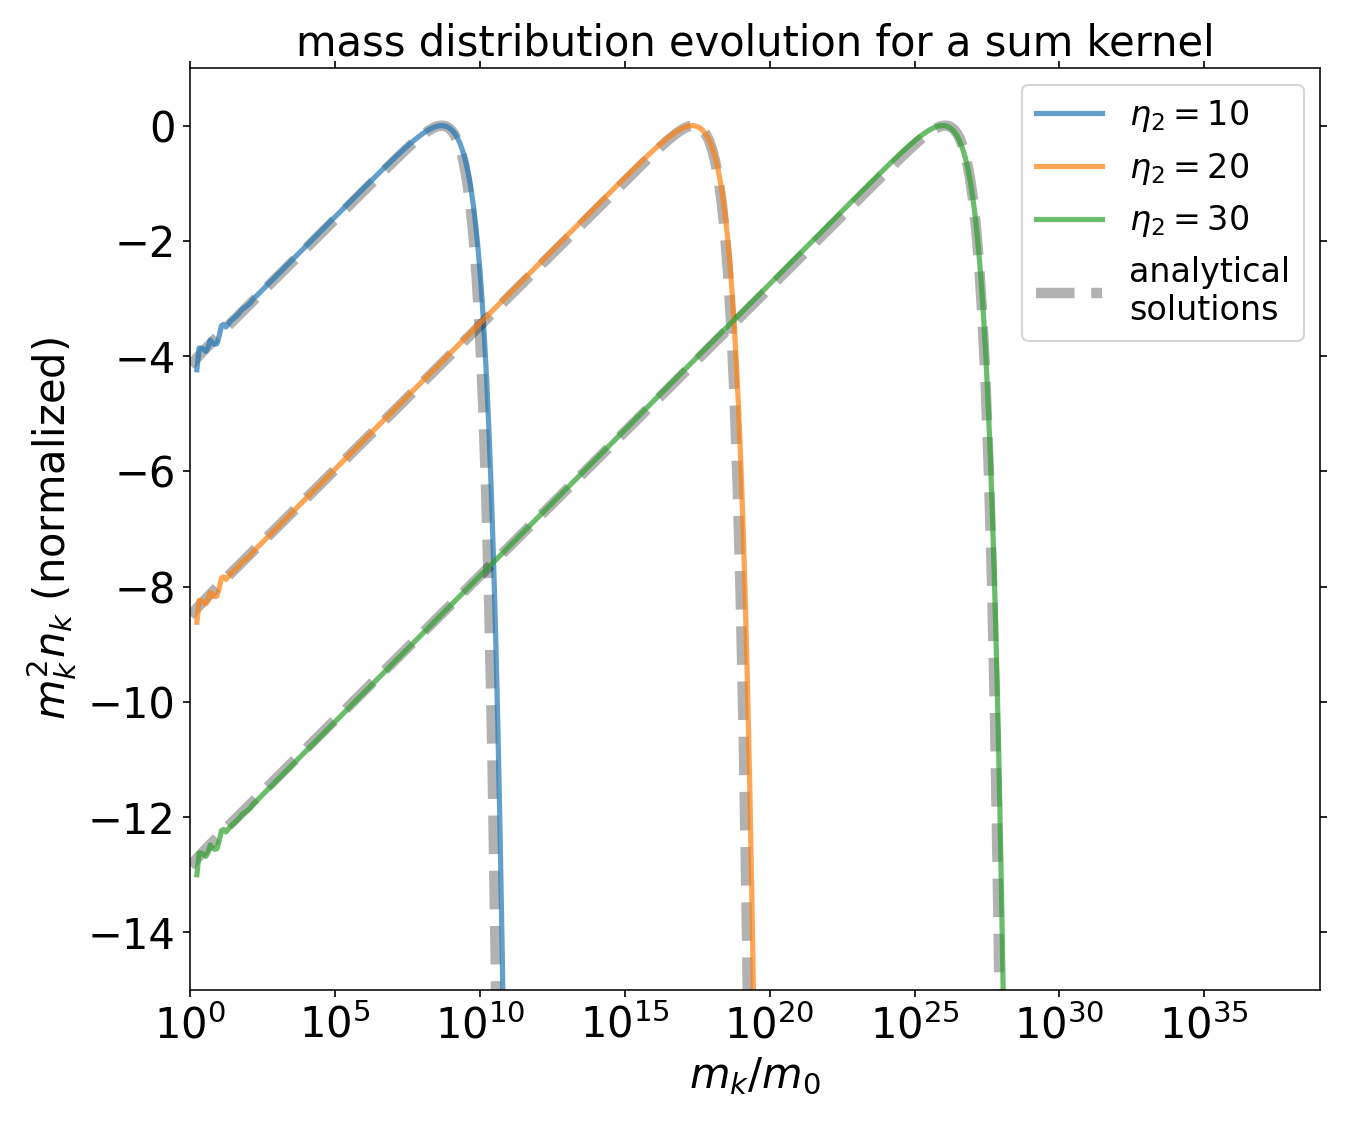

In [40]:
%%capture --no-stdout --no-display
rd = RubbleData("sumK_longer.dat")
fig, ax = plt.subplots(figsize=(9, 7.5)); maxis = rd.m[2:-1]/rd.m[1]
for ntp in [10, 20, 30]:
    f = mp.exp(-ntp); 
    #lgf = (k-1)*lgk - lgkfac + mp.log10(f) + (k-1)*mp.log10(1-f) + (-k*(1-f))*mp.log10(np.e)
    f_nk = (k-1)*lgk - lgkfac + mplog10(f * (1-f)**(k-1) * mpexp(-k*(1-f)) * k**2)
    ax.semilogx(k, f_nk - f_nk.max(), '--k', lw=5, alpha=0.3)
    
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * eta2))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.semilogx(maxis, np.log10(tmp_N / tmp_N.max()), lw=2.5, alpha=0.7, label=f'$\eta_2 = {ntp}$')
ax.semilogx([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2, fontsize=16)
ax.set(ylim=(-15, 1), xlim=(1, 1e39), xlabel=r'$m_k/m_0$', ylabel=r"$m_k^2 n_k$ (normalized)",
       title=r'mass distribution evolution for a sum kernel')     
fig.tight_layout();

# Product Kernel ($K_{ij}=m_i m_j$)

The solution for $A_{ij} = \gamma_c m_i  m_j$ and $\eta_3 \equiv \gamma n_0 t < 1$ is

$$ n_k = n_0 \frac{(2k)^{k-1}}{k!k} (\eta_3/2)^{k-1} \exp [-k\eta_3]. $$

This solution fails to conserve mass for $\eta_3 > 1$ since runaway growth happens when $\eta_3 = 1$; a single runaway body then contains most of the total mass. The mass of the runaway body for $\eta_3 > 1$ is

$$ m_R = n_0 \exp \left[ -\int \sum\limits_{k=1}^{N} k^2 (n_k/n_0) d\eta' \right] $$

<span style="font-size:16px"> PS: It seems Fig. 17 in Keynon & Luu (1998) has a wrong Y-label because their analytical lines match $n(M)$ without $M^2$ (e.g., the $\eta_3=1$ line goes through $\sim$(7.7, -20) in log scale).  In Fig. 5 in Ormel & Spaans (2008), their analytical lines instead match $n(M) M^2$ (or $m^2 f(m)$ in their own notation) and the $\eta=1$ line is much less steeper (e.g., goes through $\sim$(6, -3.4) in log scale w/o normalization). </span>

## Construct Analytical Solutions

In [41]:
def log_prodK_nk_with_k2(n0, k, eta3):
    n0, k, eta3 = mpmpf(n0), mpmpf(k), mpmpf(eta3)
    lgk = mplog10(k)
    return mplog10(n0) + (k-1)*(lgk+mplog10(2)) - (mplog10(mpfac(k))+lgk)\
           + mplog10((eta3/2)**(k-1) * mpexp(-k*eta3) * k**2)

In [42]:
# exp[-k(1-f)] in the analytical solution is much larger than what numpy can handle, we need mpmath
mp.mp.dps = 200
lgk = np.linspace(0, 16, 512)
mpmpf = np.frompyfunc(mp.mpf, 1, 1)
lgk = mpmpf(lgk)
k = 10**lgk
mpfac = np.frompyfunc(mp.factorial, 1, 1)
mplog10 = np.frompyfunc(mp.log10, 1, 1)
mpexp = np.frompyfunc(mp.exp, 1, 1)
lgkfac = mplog10(mpfac(k))

In [43]:
aly_k_m4 = np.zeros(512) # analytical k where (m_k)^2 * n_k = 1e-4
aly_t = np.linspace(0, 2, 512)
for idx_t, tmp_t in enumerate(aly_t):
    try:
        aly_k_m4[idx_t] = spop.root_scalar(lambda k : float(log_prodK_nk_with_k2(1, k, tmp_t)) - (-6), bracket=[1, 1e6], method='brentq').root
    except ValueError:
        aly_k_m4[idx_t] = 1e6
        
aly_nk = np.zeros([512, 512]); aly_k_axis = np.logspace(0, 6, 512)
for idx_t, tmp_t in enumerate(aly_t):
    aly_nk[idx_t] = log_prodK_nk_with_k2(1, aly_k_axis, tmp_t)
aly_nk[0, 1:] = 0; # remove inf
aly_nk[aly_nk < -100] = -100

In [44]:
from matplotlib.colors import LinearSegmentedColormap
def discretize_colormap(N, base_cmap='viridis', 
                        cut_top=False, curve_tuning=1.0):
    """
    Create an N-bin discrete colormap from the specified input map

    Parameters
    ----------
    N : int
        how many colors in the desired colormap
    base_cmap : str
        the base colormap to discretize
    cut_top : bool
        whether or not to cut the original top color (for vmax)
        e.g., useful for removing the white color when base_cmap='hot'
    """

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N+1))
    value_list = np.linspace(0, 1, N+1)**curve_tuning
    cmap_name = 'discretize ' + base.name
    if cut_top:
        return LinearSegmentedColormap.from_list(cmap_name, list(zip(value_list[:-1], color_list[:-1])), N)
    else:
        return LinearSegmentedColormap.from_list(cmap_name, list(zip(value_list, color_list)), N)

## Simulation and Comparison

In [59]:
# make the mass of the first bin = 1.0
a_min = (1.08/ (4*np.pi/3 * 1.6))**(1/3) # again tweak the first mass bin a bit
a_max = (1e6/ (4*np.pi/3 * 1.6))**(1/3)

r = Rubble(374, a_min, a_max, 0, 1.0, rho_m=1.6,
           delta_dist=a_min, coag2nearest=True,
           run_name="prodK", gamma_c=1.0) # gamma_c is the kernel coefficient: K_ij = gamma_c (m_i * m_j)

# the following line sets the kernel to product kernel
r._user_setup(test='productK')
    
n0 = r.Nk[1]; gamma_c = 1.0 ; eta3 = 1 / (gamma_c * n0)
print(n0, gamma_c * n0, eta3, eta3/dt_1yr, r.m[1]/r.m[0])

1.0 1.0 1.0 3.168808781402895e-08 1.0375192969619798


In [60]:
r.run(eta3*2/dt_1yr, (eta3/300)/dt_1yr, (eta3/100)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


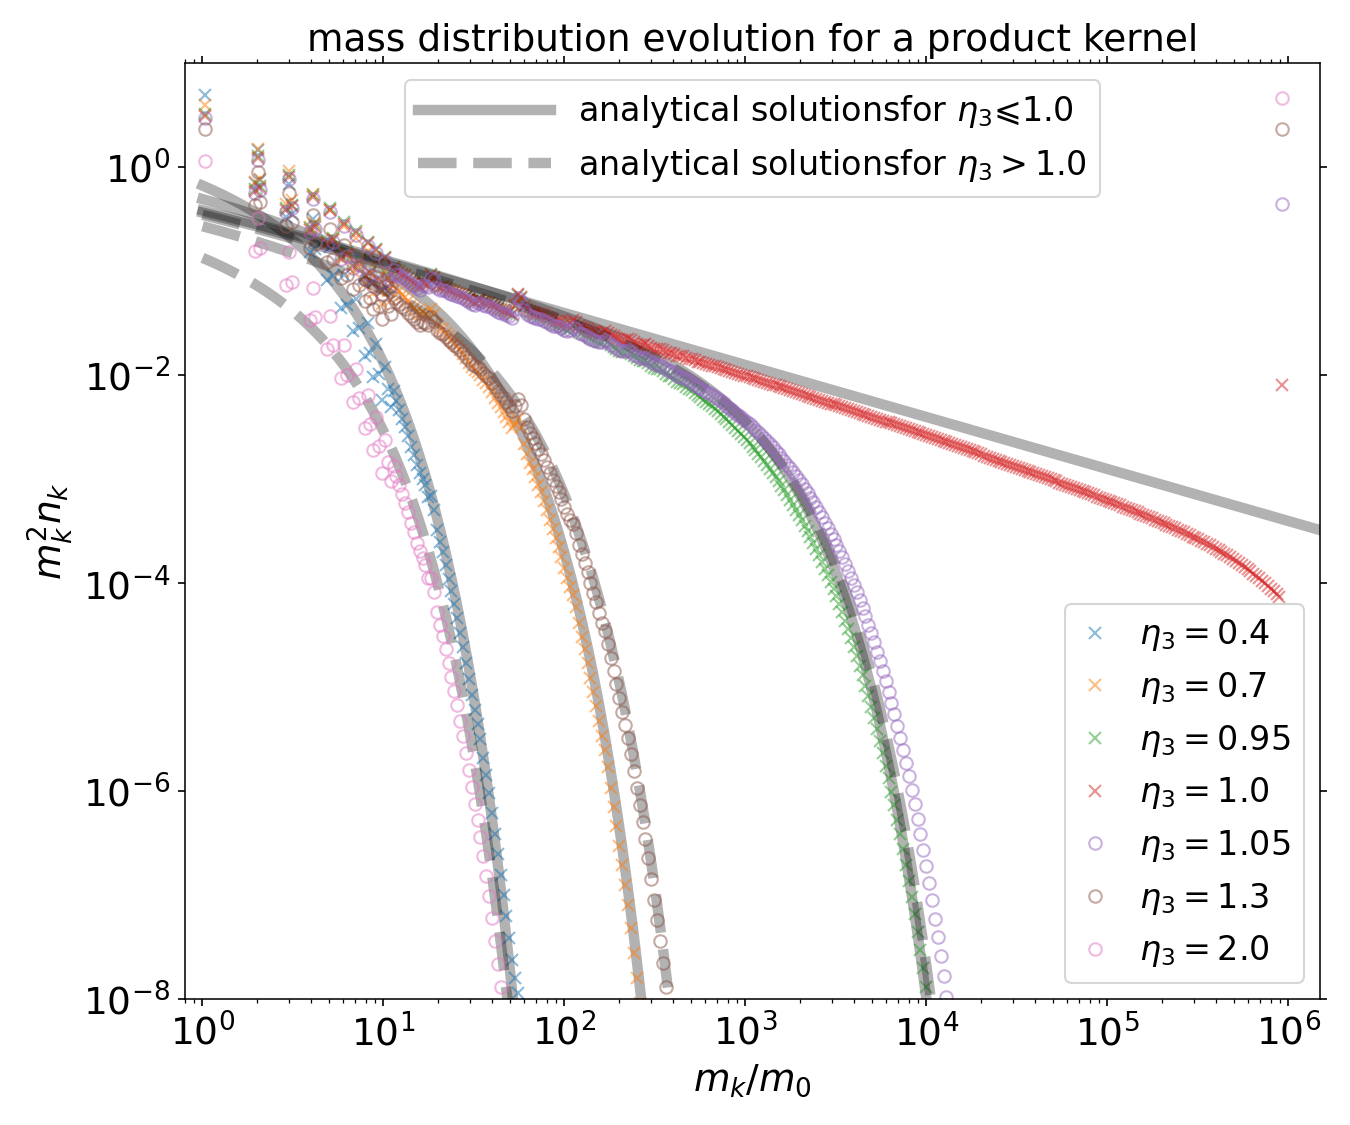

In [65]:
rd = RubbleData("prodK.dat");
fig, ax = plt.subplots(figsize=(9, 7.5)); maxis = rd.m[2:-1]/rd.m[1]
for ntp in [0.4, 0.7, 0.95, 1.0, 1.05, 1.3, 2.0]:
    f_nk = (k-1)*(lgk+mplog10(2)) - (lgkfac+lgk) + mplog10((ntp/2)**(k-1) * mpexp(-k*ntp) * k**2)
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * eta3)); tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    if ntp <= 1.0:
        ax.loglog(k, 10**f_nk, '-k', lw=5, alpha=0.3)
        ax.loglog(maxis, tmp_N, 'x', lw=2.5, alpha=0.5, label=f'$\eta_3 = {ntp}$')
    else:
        ax.loglog(k, 10**f_nk, '--k', lw=5, alpha=0.3)
        ax.loglog(maxis, tmp_N, 'o', markerfacecolor='None', lw=2.5, alpha=0.5, label=f'$\eta_3 = {ntp}$')
ax.set_yscale('symlog');
ax.loglog([], [], '-k', lw=5, alpha=0.3, label='analytical solutions'+r"for $\eta_3 \leqslant 1.0$");
ax.loglog([], [], '--k', lw=5, alpha=0.3, label='analytical solutions'+r"for $\eta_3 > 1.0$"); 
leg1 = ax.legend(ax.lines[1:-2:2], [l.get_label() for l in ax.lines[1:-2:2]], loc='lower right', handlelength=1, fontsize=16)
ax.legend(ax.lines[-2:], [l.get_label() for l in ax.lines[-2:]], loc='upper center', handlelength=4, fontsize=16)
ax.add_artist(leg1)

ax.set(xlabel=r'$m_k/m_0$', ylabel=r"$m_k^2 n_k$", xlim=(0.8, 1.5e6), ylim=(1e-8, 10), title="mass distribution evolution for a product kernel");
fig.tight_layout();

<IPython.core.display.Javascript object>


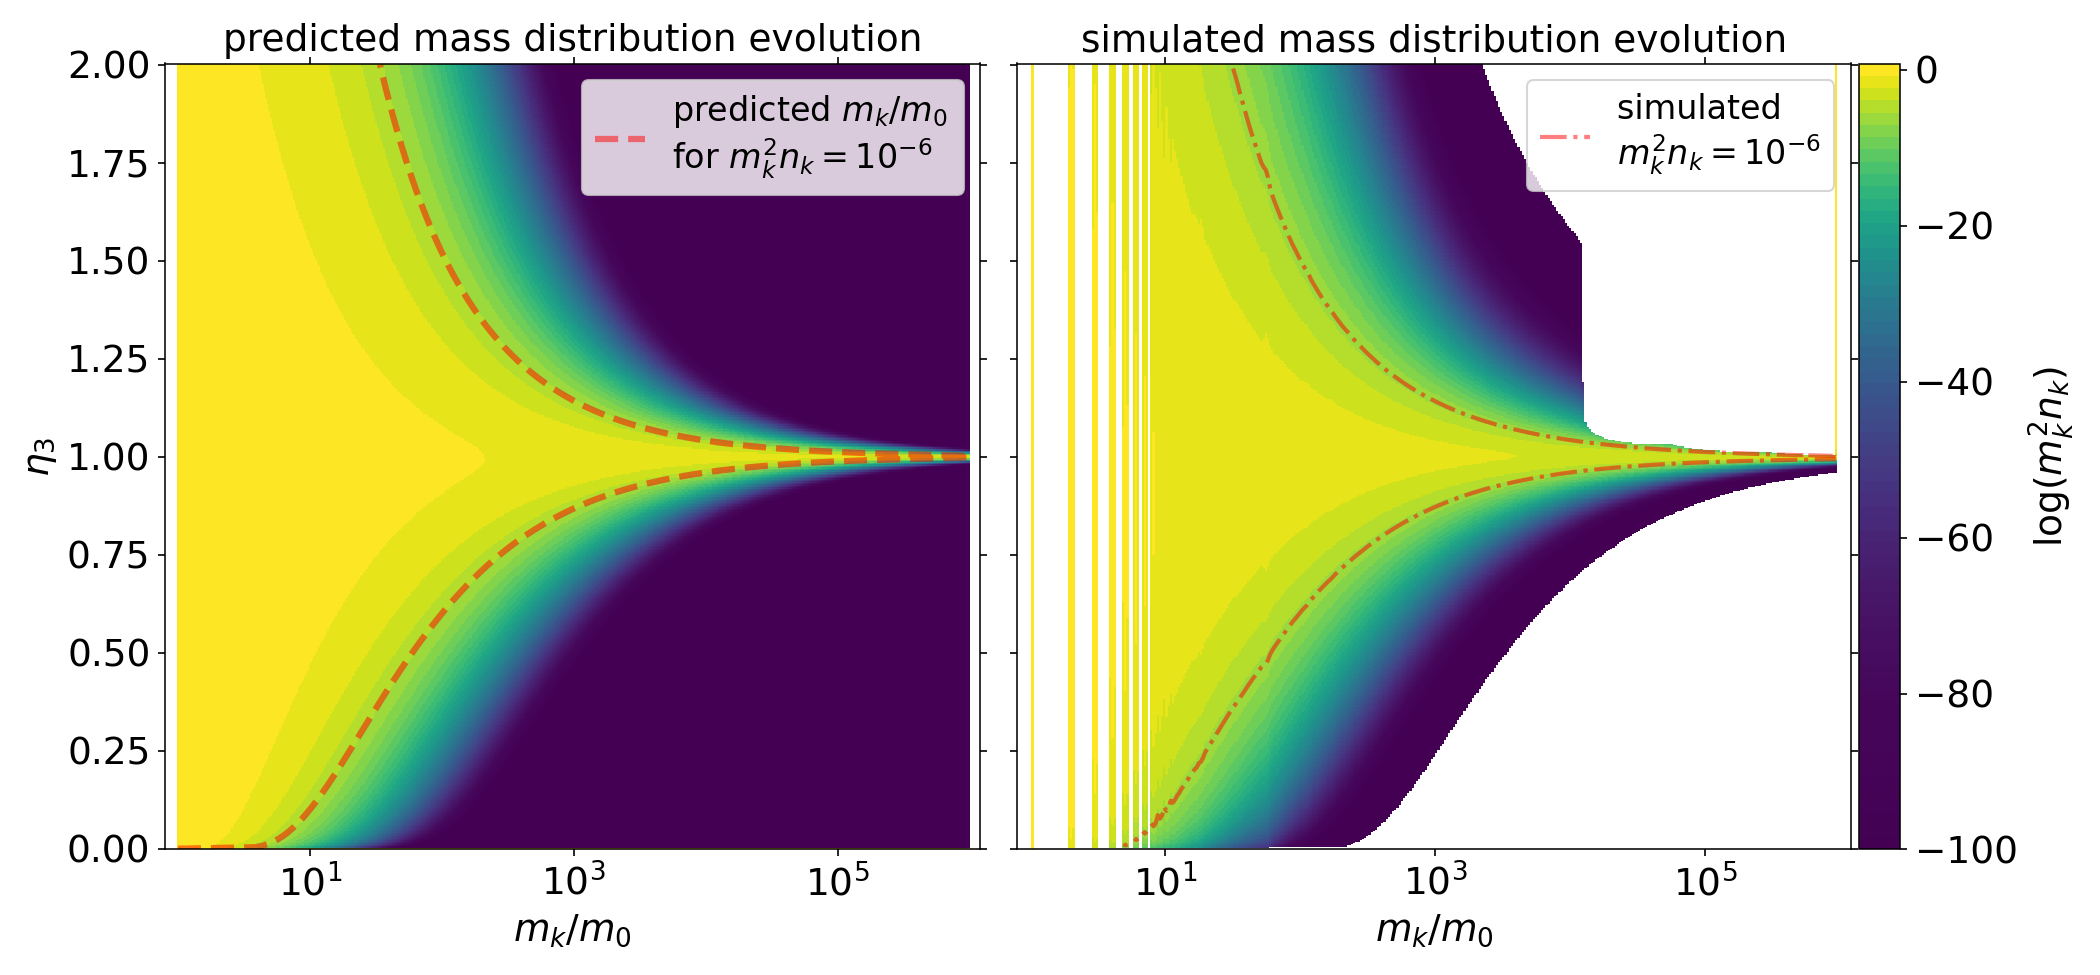

In [67]:
%%capture --no-stdout --no-display
fig, ax = plt.subplots(1, 2, figsize=(14, 6.5), sharey='row', gridspec_kw={'width_ratios':[12, 13]}); 
rd = RubbleData("productK_tests/prodK_374_108.dat");
im = ax[0].pcolormesh(aly_k_axis, aly_t, aly_nk, shading='auto', vmin=-100, cmap = discretize_colormap(64, curve_tuning=0.4), rasterized=True)
ax[0].plot(aly_k_m4, aly_t, '--r', lw=3, alpha=0.5, label=r"predicted $m_k/m_0$ "+'\n'+"for $m_k^2 n_k=10^{-6}$"); 
ax[0].set_xscale('log'); ax[0].set(xlim=[0.8, 1.2e6])
maxis = rd.m[2:-1] / rd.m[1]; sim_nk = (rd.Nk[:, 2:-1] + 0.5 * (rd.Nk[:, 3:] + rd.Nk[:, 1:-2])) / (rd.m[3:] - rd.m[1:-2]) * maxis**2
im = ax[1].pcolormesh(maxis, rd.t*dt_1yr, np.log10(sim_nk), shading='auto', vmin=-100, cmap = discretize_colormap(64, curve_tuning=0.4), rasterized=True)
cax = rxplt.add_aligned_colorbar(fig, ax[1], im); ax[1].set_xscale('log'); ax[1].set(xlim=[0.8, 1.2e6])
cax.ax.set_ylabel(r"$\log(m_k^2 n_k)$")
#ax[0].contour(maxis, rd.t*dt_1yr, np.log10(sim_nk), levels=[-6], colors=('m',), alpha=(0.7), linestyles=('-.',))
ax[1].contour(maxis, rd.t*dt_1yr, np.log10(sim_nk), levels=[-6], colors=('red',), linewidths=(2, ), alpha=(0.5), linestyles=('-.',))
ax[1].plot([], [], '-.r', lw=2, alpha=0.5, label=r"simulated "+'\n'+r"$m_k^2 n_k=10^{-6}$"); ax[0].legend(loc='upper right', fontsize=16)
ax[0].set(xlabel=r'$m_k/m_0$', ylabel=r"$\eta_3$", title=r"predicted mass distribution evolution")
ax[1].set(xlabel=r'$m_k/m_0$', title=r"simulated mass distribution evolution"); ax[1].legend(loc='upper right', fontsize=16)
fig.tight_layout();